In [130]:
import pandas as pd
import numpy as np
from datetime import datetime

In [131]:
df = pd.read_excel("bancodedados.xlsx")
df.head()

,Dates,BNTNB 6 05/15/2029 Govt,BNTNB 6 08/15/2050 Govt,ODF27 Comdty,ODF30 Comdty,USGG10YR Index,TY1 Comdty,CNH Curncy,USDBRL Curncy,EUR Curncy,SPX Index,IBOV Index
0,2023-01-02,NaN,3947.108,12.918,12.933,3.8748,112.296875,6.9270,5.3597,1.0667,3839.50,106376.02
1,2023-01-03,NaN,3947.108,13.155,13.134,3.7389,112.640625,6.9237,5.4627,1.0548,3824.14,104165.74
2,2023-01-04,NaN,3877.922,13.318,13.287,3.6827,113.187500,6.8995,5.4316,1.0604,3852.97,105334.46
3,2023-01-05,NaN,3877.922,13.055,13.025,3.7181,113.015625,6.8884,5.3529,1.0522,3808.10,107641.32
4,2023-01-06,NaN,3877.922,12.815,12.832,3.5580,114.218750,6.8303,5.2250,1.0644,3895.08,108963.70


In [132]:
rename_map = {
    "Dates": "Data",
    "BNTNB 6 05/15/2029 Govt": "NTNB-2029P",    # PU da NTN-B 2029
    "BNTNB 6 08/15/2050 Govt": "NTNB-2050P",    # PU da NTN-B 2050
    "ODF27 Comdty": "DI1F27_taxa",              # Taxa DI jan/2027 (% a.a.)
    "ODF30 Comdty": "DI1F30_taxa",              # Taxa DI jan/2030 (% a.a.)
    "USGG10YR Index": "T10_taxa",               # Yield to maturity Treasury 10y (% a.a.)
    "TY1 Comdty": "T10_fut",                    # Preço do contrato futuro de Treasury 10y
    "CNH Curncy": "CNY_USD",                    # Yuan por dólar (precisa multiplicar por USD/BRL para ter CNY em reais)
    "USDBRL Curncy": "USD_BRL",                 # Reais por dólar (já em BRL)
    "EUR Curncy": "EUR_USD",                    # Euros por dólar (precisa multiplicar por USD/BRL para ter EUR em reais)
    "SPX Index": "S&P500",                      # Pontos do índice S&P500 (precisa multiplicar por USD/BRL para ter em BRL)
    "IBOV Index": "IBOV"                        # Pontos do Ibovespa (já em BRL)
}

In [133]:
df.rename(columns=rename_map, inplace=True)

In [134]:
df.drop(df.index[-1], inplace=True)

In [135]:
df["Data"] = pd.to_datetime(df["Data"])

In [136]:
# Definir vencimentos
venc_DI1F27 = datetime(2027, 1, 1)
venc_DI1F30 = datetime(2030, 1, 1)
prazo_T10 = 10  # anos

# Função para dias úteis (simplificação: considerar todos dias como úteis para exemplo)
def dias_uteis(data_inicial, data_final):
    return np.busday_count(data_inicial.date(), data_final.date())

# Converter DI1F27 e DI1F30 de taxa (% a.a.) para preço usando fórmula PU = 1000 / (1 + r)^(d/252)
for col, venc in [("DI1F27_taxa", venc_DI1F27), ("DI1F30_taxa", venc_DI1F30)]:
    dias_restantes = df["Data"].apply(lambda d: dias_uteis(d, venc))
    df[col.replace("_taxa", "_preco")] = 1000 / (1 + df[col] / 100) ** (dias_restantes / 252)

# Converter T10_taxa (Treasury 10y) como se fosse zero cupom: Preço ≈ 100 / (1 + r)^10
df["T10_preco"] = 100 / (1 + df["T10_taxa"] / 100) ** prazo_T10

# Remover colunas de taxa
df.drop(columns=["DI1F27_taxa", "DI1F30_taxa", "T10_taxa"], inplace=True)

In [137]:
df.head()

,Data,NTNB-2029P,NTNB-2050P,T10_fut,CNY_USD,USD_BRL,EUR_USD,S&P500,IBOV,DI1F27_preco,DI1F30_preco,T10_preco
0,2023-01-02,NaN,3947.108,112.296875,6.9270,5.3597,1.0667,3839.50,106376.02,604.518636,414.246011,68.375103
1,2023-01-03,NaN,3947.108,112.640625,6.9237,5.4627,1.0548,3824.14,104165.74,599.584389,409.142938,69.276129
2,2023-01-04,NaN,3877.922,113.187500,6.8995,5.4316,1.0604,3852.97,105334.46,596.318598,405.358653,69.652550
3,2023-01-05,NaN,3877.922,113.015625,6.8884,5.3529,1.0522,3808.10,107641.32,602.368815,412.409633,69.415184
4,2023-01-06,NaN,3877.922,114.218750,6.8303,5.2250,1.0644,3895.08,108963.70,607.970981,417.740178,70.495835


In [138]:
# ==== Conversões para BRL ====
# CNY_BRL = USD_BRL / CNY_USD
df["CNY_BRL"] = df["USD_BRL"] / df["CNY_USD"]

# EUR_USD = USD por EUR. Para obter BRL por EUR:
# EUR_BRL = USD_BRL * EUR_USD
df["EUR_BRL"] = df["USD_BRL"] * df["EUR_USD"]

# S&P500 está em pontos USD; para "preço em BRL", multiplicamos pelos BRL por USD
df["S&P500_BRL"] = df["S&P500"] * df["USD_BRL"]

# T10_fut em USD; para BRL:
if "T10_fut" in df:
    df["T10_fut_BRL"] = df["T10_fut"] * df["USD_BRL"]

In [139]:
df.head()

,Data,NTNB-2029P,NTNB-2050P,T10_fut,CNY_USD,USD_BRL,EUR_USD,S&P500,IBOV,DI1F27_preco,DI1F30_preco,T10_preco,CNY_BRL,EUR_BRL,S&P500_BRL,T10_fut_BRL
0,2023-01-02,NaN,3947.108,112.296875,6.9270,5.3597,1.0667,3839.50,106376.02,604.518636,414.246011,68.375103,0.773740,5.717192,20578.568150,601.877561
1,2023-01-03,NaN,3947.108,112.640625,6.9237,5.4627,1.0548,3824.14,104165.74,599.584389,409.142938,69.276129,0.788986,5.762056,20890.129578,615.321942
2,2023-01-04,NaN,3877.922,113.187500,6.8995,5.4316,1.0604,3852.97,105334.46,596.318598,405.358653,69.652550,0.787245,5.759669,20927.791852,614.789225
3,2023-01-05,NaN,3877.922,113.015625,6.8884,5.3529,1.0522,3808.10,107641.32,602.368815,412.409633,69.415184,0.777089,5.632321,20384.378490,604.961339
4,2023-01-06,NaN,3877.922,114.218750,6.8303,5.2250,1.0644,3895.08,108963.70,607.970981,417.740178,70.495835,0.764974,5.561490,20351.793000,596.792969


In [140]:
# Opcional: manter apenas colunas finais organizadas
cols_order = [
    "Data",
    "NTNB-2029P", "NTNB-2050P",
    "DI1F27_preco", "DI1F30_preco",
    "T10_fut_BRL",
    "USD_BRL", "CNY_BRL", "EUR_BRL",
    "S&P500_BRL",
    "IBOV"
]
cols_exist = [c for c in cols_order if c in df.columns]
df_brl = df[cols_exist].copy()

In [141]:
df_brl.head()

,Data,NTNB-2029P,NTNB-2050P,DI1F27_preco,DI1F30_preco,T10_fut_BRL,USD_BRL,CNY_BRL,EUR_BRL,S&P500_BRL,IBOV
0,2023-01-02,NaN,3947.108,604.518636,414.246011,601.877561,5.3597,0.773740,5.717192,20578.568150,106376.02
1,2023-01-03,NaN,3947.108,599.584389,409.142938,615.321942,5.4627,0.788986,5.762056,20890.129578,104165.74
2,2023-01-04,NaN,3877.922,596.318598,405.358653,614.789225,5.4316,0.787245,5.759669,20927.791852,105334.46
3,2023-01-05,NaN,3877.922,602.368815,412.409633,604.961339,5.3529,0.777089,5.632321,20384.378490,107641.32
4,2023-01-06,NaN,3877.922,607.970981,417.740178,596.792969,5.2250,0.764974,5.561490,20351.793000,108963.70


In [142]:
df_brl = df_brl.iloc[276:].reset_index(drop=True) #276 temos NTNB-2029P com NaN
df_brl.head()

,Data,NTNB-2029P,NTNB-2050P,DI1F27_preco,DI1F30_preco,T10_fut_BRL,USD_BRL,CNY_BRL,EUR_BRL,S&P500_BRL,IBOV
0,2024-01-23,4341.021,4491.526,748.928889,540.570665,550.566178,4.9503,0.690669,5.373056,24081.229380,128262.52
1,2024-01-24,4341.021,4499.201,749.625818,541.326949,547.386650,4.9328,0.688717,5.369353,24015.583440,127815.70
2,2024-01-25,4352.082,4506.861,751.943274,543.683846,547.279037,4.9166,0.684773,5.332544,24062.627056,128168.73
3,2024-01-26,4352.082,4520.395,753.201208,545.169552,545.263366,4.9109,0.683161,5.329800,24019.064573,128967.32
4,2024-01-29,4352.082,4512.293,752.378592,543.387151,551.779313,4.9480,0.688417,5.360168,24383.397640,128502.66


## 📈 Análise Econômica dos Títulos e Ativos

A base contempla diferentes classes de ativos, cada uma refletindo um conjunto distinto de riscos macroeconômicos e oportunidades de diversificação.

### 1. **Títulos Públicos Federais Indexados à Inflação (NTNB)**
- **NTNB-2029P** e **NTNB-2050P** são Notas do Tesouro Nacional Série B, indexadas ao IPCA.
- O investidor recebe um cupom real fixo, além da variação da inflação, sendo títulos de **juros reais**.
- Sensibilidade elevada à taxa de juro real de longo prazo:
  - **Alta nos preços** → queda na taxa real exigida pelo mercado.
  - **Queda nos preços** → aumento na taxa real exigida, geralmente associado a incertezas fiscais ou choques inflacionários.
- NTNB-2050P tem **duration muito maior** que a 2029P, amplificando os movimentos de preço.

### 2. **Contratos Futuros de Taxa DI**
- **DI1F27_preco** e **DI1F30_preco** representam preços equivalentes de contratos futuros de Depósitos Interfinanceiros (DI) com vencimento em janeiro/2027 e janeiro/2030.
- Derivam diretamente das expectativas de **Selic futura**:
  - Preço mais alto → mercado projeta queda na taxa Selic.
  - Preço mais baixo → mercado projeta alta na Selic.
- Afetados por:
  - Decisões do Copom.
  - Projeções de inflação.
  - Fluxo de capital estrangeiro.

### 3. **Treasury Americano de 10 anos (T10_fut_BRL)**
- Preço do contrato futuro do Treasury de 10 anos, convertido para BRL.
- Reflete a taxa de juro americana de médio/longo prazo e o câmbio BRL/USD.
- Ativo de referência global para **"risk-free rate"**.
- Tende a se valorizar em cenários de aversão ao risco, quando investidores buscam segurança.

### 4. **Moedas**
- **USD_BRL**: Cotação do dólar americano em reais, principal termômetro do risco-país e fluxo de capitais.
- **CNY_BRL**: Yuan offshore convertido para BRL, importante dado o peso da China como parceiro comercial do Brasil.
- **EUR_BRL**: Euro convertido para BRL, representando relação com a economia europeia e diversificação cambial.

### 5. **Renda Variável**
- **S&P500_BRL**: Índice S&P500 convertido para BRL, capturando performance das ações americanas e variação cambial.
- **IBOV**: Índice Bovespa em pontos, principal indicador do mercado acionário brasileiro.
- Correlação geralmente positiva entre S&P500_BRL e IBOV, mas com impacto distinto de fatores domésticos.

---

### 📌 Observações Estratégicas
- **Hedge cambial**: USD_BRL, CNY_BRL e EUR_BRL podem proteger a carteira em cenários de desvalorização do real.
- **Sensibilidade a juros**: NTNBs longas e DIs futuros respondem fortemente a mudanças na política monetária.
- **Diversificação global**: T10_fut_BRL e S&P500_BRL oferecem exposição internacional e descorrelação parcial com ativos domésticos.


📌 Matriz de Correlação


,NTNB-2029P,NTNB-2050P,DI1F27_preco,DI1F30_preco,T10_fut_BRL,USD_BRL,CNY_BRL,EUR_BRL,S&P500_BRL,IBOV
NTNB-2029P,1.000000,0.212031,0.272778,0.287199,-0.050005,-0.099590,-0.073879,-0.041925,-0.086546,0.155085
NTNB-2050P,0.212031,1.000000,0.280048,0.336781,-0.209577,-0.235048,-0.231155,-0.164975,-0.118448,0.200314
DI1F27_preco,0.272778,0.280048,1.000000,0.922274,-0.340792,-0.520924,-0.471975,-0.367282,-0.362785,0.457984
DI1F30_preco,0.287199,0.336781,0.922274,1.000000,-0.383933,-0.550004,-0.495990,-0.395660,-0.335212,0.496028
T10_fut_BRL,-0.050005,-0.209577,-0.340792,-0.383933,1.000000,0.901361,0.880908,0.826697,0.263626,-0.491523
USD_BRL,-0.099590,-0.235048,-0.520924,-0.550004,0.901361,1.000000,0.942582,0.823490,0.361674,-0.588650
CNY_BRL,-0.073879,-0.231155,-0.471975,-0.495990,0.880908,0.942582,1.000000,0.873082,0.327616,-0.554085
EUR_BRL,-0.041925,-0.164975,-0.367282,-0.395660,0.826697,0.823490,0.873082,1.000000,0.191395,-0.489386
S&P500_BRL,-0.086546,-0.118448,-0.362785,-0.335212,0.263626,0.361674,0.327616,0.191395,1.000000,-0.071995
IBOV,0.155085,0.200314,0.457984,0.496028,-0.491523,-0.588650,-0.554085,-0.489386,-0.071995,1.000000


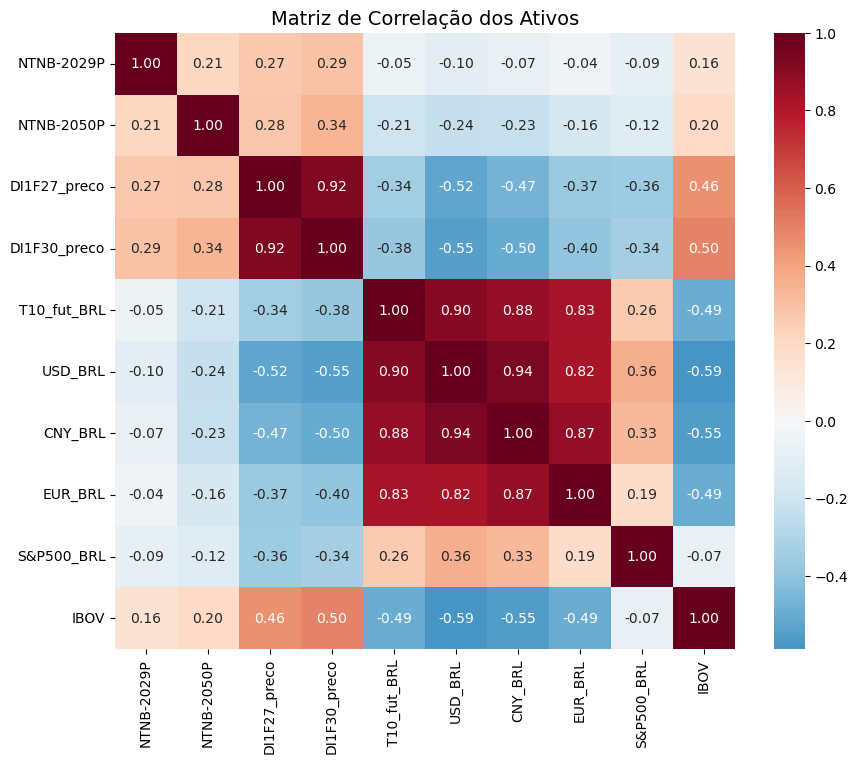

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Retornos logarítmicos (já usados no Markowitz)
price_cols = [c for c in df_brl.columns if c != 'Data']
log_returns = np.log(df_brl[price_cols] / df_brl[price_cols].shift(1)).dropna()

# Matriz de correlação
corr_matrix = log_returns.corr()

print("📌 Matriz de Correlação")
display(corr_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Matriz de Correlação dos Ativos", fontsize=14)
plt.show()


In [144]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# ===============================
# 1. Mapeamento dos grupos
# ===============================
grupos = {
    'NTNB-2029P'    : 'IPCA + Pré',
    'NTNB-2050P'    : 'IPCA + Pré',
    'DI1F27_preco'  : 'IPCA + Pré',
    'DI1F30_preco'  : 'IPCA + Pré',
    'T10_fut_BRL'   : 'Treasury',
    'USD_BRL'       : 'US$',
    'CNY_BRL'       : 'Yuan',
    'EUR_BRL'       : 'Euro',
    'S&P500_BRL'    : 'S&P',
    'IBOV'          : 'IBOVESPA'
}

# ===============================
# 2. Limites por fator (% -> fração)
# ===============================
limites = {
    'IPCA + Pré': 2.00,  # 200%
    'US$'       : 0.30,
    'Treasury'  : 1.00,
    'S&P'       : 0.20,
    'Ações BDR' : 0.20,  # Não temos BDRs explícitos no df
    'IBOVESPA'  : 0.25,
    'Euro'      : 0.30,
    'Yuan'      : 0.30
}

# ===============================
# 3. Preparar retornos e estatísticas
# ===============================
price_cols = [c for c in df_brl.columns if c != 'Data']
log_returns = np.log(df_brl[price_cols] / df_brl[price_cols].shift(1)).dropna()

mu = log_returns.mean() * 252
S = log_returns.cov() * 252

ativos = mu.index.tolist()

# Bounds individuais
bounds = [(0, limites[grupos[a]]) for a in ativos]

# Constraints comuns
COMMON_CONSTRAINTS = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

# Limites por grupo
for grupo, limite in limites.items():
    idx = [i for i, a in enumerate(ativos) if grupos[a] == grupo]
    if idx:
        COMMON_CONSTRAINTS.append({
            'type': 'ineq',
            'fun': lambda x, idx=idx, lim=limite: lim - np.sum(x[idx])
        })

# ===============================
# 4. Funções de otimização
# ===============================
def portfolio_annualised_performance(w, mean, cov):
    ret = np.dot(w, mean)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return vol, ret

def neg_sharpe_ratio(w, mean, cov, rf):
    vol, ret = portfolio_annualised_performance(w, mean, cov)
    return -(ret - rf) / vol

def max_sharpe_ratio(mean, cov, rf):
    n = len(mean)
    res = minimize(neg_sharpe_ratio, n*[1/n], args=(mean, cov, rf),
                   method='SLSQP', bounds=bounds, constraints=COMMON_CONSTRAINTS)
    return res

def portfolio_volatility(w, mean, cov):
    return portfolio_annualised_performance(w, mean, cov)[0]

def min_variance(mean, cov):
    n = len(mean)
    res = minimize(portfolio_volatility, n*[1/n], args=(mean, cov),
                   method='SLSQP', bounds=bounds, constraints=COMMON_CONSTRAINTS)
    return res

def efficient_return(mean, cov, target):
    n = len(mean)
    def port_ret(w):
        return np.dot(w, mean)
    cons = COMMON_CONSTRAINTS + [{'type': 'eq',
                                  'fun': lambda x, t=target: port_ret(x) - t}]
    res = minimize(portfolio_volatility, n*[1/n], args=(mean, cov),
                   method='SLSQP', bounds=bounds, constraints=cons)
    return res

def efficient_frontier(mean, cov, targets):
    return [efficient_return(mean, cov, t) for t in targets]

# ===============================
# 5. Rodar otimizações
# ===============================
risk_free_rate = 0.15  # Selic anual

opt_sharpe = max_sharpe_ratio(mu.values, S.values, risk_free_rate)
opt_var = min_variance(mu.values, S.values)

vol_sharpe, ret_sharpe = portfolio_annualised_performance(opt_sharpe.x, mu.values, S.values)
vol_min, ret_min = portfolio_annualised_performance(opt_var.x, mu.values, S.values)

# Fronteira eficiente
targets = np.linspace(ret_min, ret_sharpe + 0.05, 50)
efficient_ports = efficient_frontier(mu.values, S.values, targets)

# ===============================
# 6. Simulação de carteiras aleatórias
# ===============================
n_rand = 10_000
rand_ret, rand_vol, rand_shp = [], [], []
upper_bounds = np.array([b[1] for b in bounds])

for _ in range(n_rand):
    raw = np.random.random(len(ativos)) * upper_bounds
    w = raw / raw.sum()
    vol, ret = portfolio_annualised_performance(w, mu.values, S.values)
    rand_ret.append(ret)
    rand_vol.append(vol)
    rand_shp.append((ret - risk_free_rate) / vol)

df_rand = pd.DataFrame({'ret': rand_ret, 'vol': rand_vol, 'shp': rand_shp})

def format_all_weights(series):
    # Arredonda para 4 casas para preservar detalhe
    series = series.round(4)
    return series

print("📌 Pesos - Sharpe Máximo")
display(format_all_weights(pd.Series(opt_sharpe.x, index=ativos)).to_frame("Peso"))

print("\n📌 Pesos - Mínima Variância")
display(format_all_weights(pd.Series(opt_var.x, index=ativos)).to_frame("Peso"))


📌 Pesos - Sharpe Máximo


,Peso
NTNB-2029P,0.0
NTNB-2050P,0.0
DI1F27_preco,0.0
DI1F30_preco,0.0
T10_fut_BRL,0.5
USD_BRL,0.0
CNY_BRL,0.0
EUR_BRL,0.3
S&P500_BRL,0.2
IBOV,0.0



📌 Pesos - Mínima Variância


,Peso
NTNB-2029P,0.1441
NTNB-2050P,0.0411
DI1F27_preco,0.5915
DI1F30_preco,0.0000
T10_fut_BRL,0.0000
USD_BRL,0.1422
CNY_BRL,0.0124
EUR_BRL,0.0000
S&P500_BRL,0.0431
IBOV,0.0256


## Motivação para Redução do Universo de Ativos

A partir da análise da **matriz de correlação** e do comportamento histórico dos ativos, observamos forte redundância em algumas séries.  
Como o objetivo é otimizar a carteira usando o modelo de Markowitz, é importante reduzir ativos com **alta colinearidade** para melhorar a robustez e evitar que múltiplos ativos representem o mesmo fator de risco.

### Critérios Utilizados
1. **Correlação muito alta (> 0.90)** → indica que dois ativos se movem quase de forma idêntica.
2. **Fator de risco similar** → se dois ativos representam o mesmo tipo de risco (ex.: câmbio contra BRL), mantemos apenas um.
3. **Preservar diversificação** → garantir exposição a diferentes classes de ativos: renda fixa local, renda fixa externa, câmbio e ações.

### Ajustes Realizados

**Removidos:**
- `DI1F30_preco` → Correlação de **0.92** com `DI1F27_preco`, sem ganho adicional de diversificação.
- `CNY_BRL` → Correlação de **0.94** com `USD_BRL` e alta colinearidade com outras moedas.

**Mantidos:**
- **Renda Fixa Local**:
  - `NTNB-2029P` e `NTNB-2050P` → Durations diferentes, agregam diversificação.
  - `DI1F27_preco` → Proxy das expectativas de Selic futura.
- **Renda Fixa Internacional**:
  - `T10_fut_BRL` → Exposição a Treasury americano em BRL.
- **Câmbio**:
  - `USD_BRL` → Principal indicador de risco-país e fluxo de capitais.
  - `EUR_BRL` → Diversificação para fora do eixo USD/China.
- **Renda Variável**:
  - `S&P500_BRL` → Exposição à bolsa americana e ao câmbio.
  - `IBOV` → Exposição à bolsa brasileira.

Com este ajuste, reduzimos redundância e mantemos **exposição balanceada** a múltiplos fatores de risco.


In [145]:
ativos_mantidos = [
    'NTNB-2029P',
    'NTNB-2050P',
    'DI1F27_preco',
    'T10_fut_BRL',
    'USD_BRL',
    'EUR_BRL',
    'S&P500_BRL',
    'IBOV'
]
df_filtered = df_brl[['Data'] + ativos_mantidos].copy()
df_filtered.head()

,Data,NTNB-2029P,NTNB-2050P,DI1F27_preco,T10_fut_BRL,USD_BRL,EUR_BRL,S&P500_BRL,IBOV
0,2024-01-23,4341.021,4491.526,748.928889,550.566178,4.9503,5.373056,24081.229380,128262.52
1,2024-01-24,4341.021,4499.201,749.625818,547.386650,4.9328,5.369353,24015.583440,127815.70
2,2024-01-25,4352.082,4506.861,751.943274,547.279037,4.9166,5.332544,24062.627056,128168.73
3,2024-01-26,4352.082,4520.395,753.201208,545.263366,4.9109,5.329800,24019.064573,128967.32
4,2024-01-29,4352.082,4512.293,752.378592,551.779313,4.9480,5.360168,24383.397640,128502.66


📌 Matriz de Correlação


,NTNB-2029P,NTNB-2050P,DI1F27_preco,T10_fut_BRL,USD_BRL,EUR_BRL,S&P500_BRL,IBOV
NTNB-2029P,1.000000,0.212031,0.272778,-0.050005,-0.099590,-0.041925,-0.086546,0.155085
NTNB-2050P,0.212031,1.000000,0.280048,-0.209577,-0.235048,-0.164975,-0.118448,0.200314
DI1F27_preco,0.272778,0.280048,1.000000,-0.340792,-0.520924,-0.367282,-0.362785,0.457984
T10_fut_BRL,-0.050005,-0.209577,-0.340792,1.000000,0.901361,0.826697,0.263626,-0.491523
USD_BRL,-0.099590,-0.235048,-0.520924,0.901361,1.000000,0.823490,0.361674,-0.588650
EUR_BRL,-0.041925,-0.164975,-0.367282,0.826697,0.823490,1.000000,0.191395,-0.489386
S&P500_BRL,-0.086546,-0.118448,-0.362785,0.263626,0.361674,0.191395,1.000000,-0.071995
IBOV,0.155085,0.200314,0.457984,-0.491523,-0.588650,-0.489386,-0.071995,1.000000


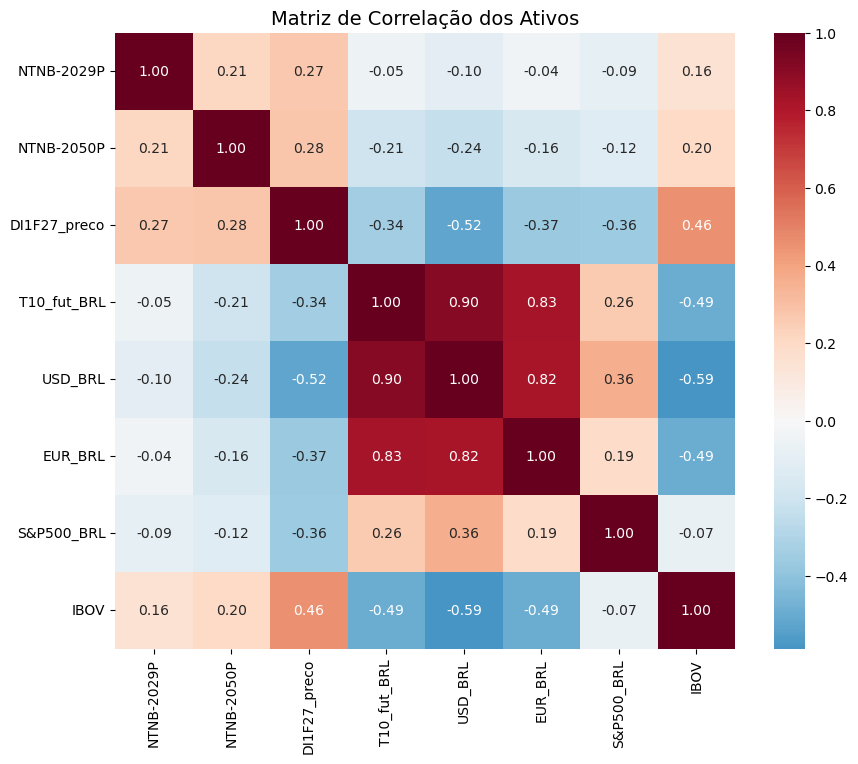

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Retornos logarítmicos (já usados no Markowitz)
price_cols = [c for c in df_filtered.columns if c != 'Data']
log_returns = np.log(df_filtered[price_cols] / df_filtered[price_cols].shift(1)).dropna()

# Matriz de correlação
corr_matrix = log_returns.corr()

print("📌 Matriz de Correlação")
display(corr_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Matriz de Correlação dos Ativos", fontsize=14)
plt.show()


In [147]:
# ===============================
# 1) Retornos e estatísticas
# ===============================
price_cols = [c for c in df_filtered.columns if c != 'Data']
log_returns = np.log(df_filtered[price_cols] / df_filtered[price_cols].shift(1)).dropna()

mu = log_returns.mean() * 252
S  = log_returns.cov()   * 252
ativos = mu.index.tolist()

# ===============================
# 2) Grupos e limites (da tabela)
# ===============================
grupos = {
    'NTNB-2029P'   : 'IPCA + Pré',
    'NTNB-2050P'   : 'IPCA + Pré',
    'DI1F27_preco' : 'IPCA + Pré',
    'T10_fut_BRL'  : 'Treasury',
    'USD_BRL'      : 'US$',
    'EUR_BRL'      : 'Euro',
    'S&P500_BRL'   : 'S&P',
    'IBOV'         : 'IBOVESPA'
}
limites = {
    'IPCA + Pré': 2.00,   # 200%
    'US$'       : 0.30,
    'Treasury'  : 1.00,
    'S&P'       : 0.20,
    'IBOVESPA'  : 0.25,
    'Euro'      : 0.30
}

# ===============================
# 3) Bounds e constraints (para este subset)
# ===============================
bounds = [(0, limites[grupos[a]]) for a in ativos]

COMMON_CONSTRAINTS = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
for grupo, limite in limites.items():
    idx = [i for i, a in enumerate(ativos) if grupos[a] == grupo]
    if idx:
        COMMON_CONSTRAINTS.append({
            'type': 'ineq',
            'fun' : lambda x, idx=idx, lim=limite: lim - np.sum(x[idx])
        })

In [148]:
# ===============================
# 4) Funções de otimização (agora recebem bounds/constraints)
# ===============================
def portfolio_annualised_performance(w, mean, cov):
    ret = np.dot(w, mean)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return vol, ret

def neg_sharpe_ratio(w, mean, cov, rf):
    vol, ret = portfolio_annualised_performance(w, mean, cov)
    return -(ret - rf) / (vol + 1e-12)

def max_sharpe_ratio(mean, cov, rf, bounds, constraints):
    n = len(mean)
    res = minimize(neg_sharpe_ratio, x0=np.full(n, 1/n),
                   args=(mean, cov, rf),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return res

def portfolio_volatility(w, mean, cov):
    return portfolio_annualised_performance(w, mean, cov)[0]

def min_variance(mean, cov, bounds, constraints):
    n = len(mean)
    res = minimize(portfolio_volatility, x0=np.full(n, 1/n),
                   args=(mean, cov),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return res

def efficient_return(mean, cov, target, bounds, base_constraints):
    n = len(mean)
    def port_ret(w): return np.dot(w, mean)
    cons = base_constraints + [{'type': 'eq', 'fun': lambda x, t=target: port_ret(x) - t}]
    res = minimize(portfolio_volatility, x0=np.full(n, 1/n),
                   args=(mean, cov),
                   method='SLSQP', bounds=bounds, constraints=cons)
    return res

def efficient_frontier(mean, cov, targets, bounds, constraints):
    return [efficient_return(mean, cov, t, bounds, constraints) for t in targets]

# ===============================
# 5) Otimizações
# ===============================
risk_free_rate = 0.15  # Selic anual (ajuste se quiser CDI efetivo do período)

opt_sharpe = max_sharpe_ratio(mu.values, S.values, risk_free_rate, bounds, COMMON_CONSTRAINTS)
opt_var    = min_variance   (mu.values, S.values,                    bounds, COMMON_CONSTRAINTS)

vol_sharpe, ret_sharpe = portfolio_annualised_performance(opt_sharpe.x, mu.values, S.values)
vol_min,    ret_min    = portfolio_annualised_performance(opt_var.x,    mu.values, S.values)

# Fronteira eficiente
targets = np.linspace(ret_min, ret_sharpe + 0.05, 50)
efficient_ports = efficient_frontier(mu.values, S.values, targets, bounds, COMMON_CONSTRAINTS)

# ===============================
# 6) Impressão dos pesos (mantendo todos os ativos)
# ===============================
def format_all_weights(series):
    return series.round(4)

print("📌 Pesos - Sharpe Máximo (Filtrado)")
print((format_all_weights(pd.Series(opt_sharpe.x, index=ativos)) * 100).round(2).astype(str) + " %")

print("\n📌 Pesos - Mínima Variância (Filtrado)")
print((format_all_weights(pd.Series(opt_var.x, index=ativos)) * 100).round(2).astype(str) + " %")


📌 Pesos - Sharpe Máximo (Filtrado)
NTNB-2029P       0.0 %
NTNB-2050P       0.0 %
DI1F27_preco     0.0 %
T10_fut_BRL     50.0 %
USD_BRL          0.0 %
EUR_BRL         30.0 %
S&P500_BRL      20.0 %
IBOV             0.0 %
dtype: object

📌 Pesos - Mínima Variância (Filtrado)
NTNB-2029P      14.55 %
NTNB-2050P       4.12 %
DI1F27_preco    58.76 %
T10_fut_BRL       0.0 %
USD_BRL         15.57 %
EUR_BRL           0.0 %
S&P500_BRL       4.22 %
IBOV             2.77 %
dtype: object


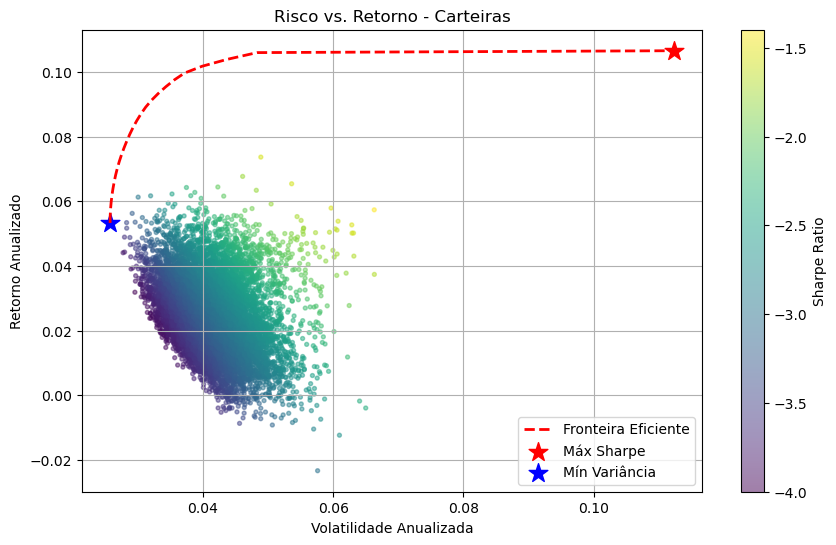

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# 📌 Carteiras aleatórias
plt.scatter(df_rand['vol'], df_rand['ret'], c=df_rand['shp'], cmap='viridis', s=8, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# 📌 Fronteira eficiente
fe_vol = [portfolio_annualised_performance(p.x, mu.values, S.values)[0] for p in efficient_ports]
fe_ret = [portfolio_annualised_performance(p.x, mu.values, S.values)[1] for p in efficient_ports]
plt.plot(fe_vol, fe_ret, 'r--', linewidth=2, label='Fronteira Eficiente')

# 📌 Máx Sharpe
plt.scatter(vol_sharpe, ret_sharpe, c='red', marker='*', s=200, label='Máx Sharpe')

# 📌 Mín Variância
plt.scatter(vol_min, ret_min, c='blue', marker='*', s=200, label='Mín Variância')

plt.xlabel('Volatilidade Anualizada')
plt.ylabel('Retorno Anualizado')
plt.title('Risco vs. Retorno - Carteiras')
plt.legend()
plt.grid(True)
plt.show()
